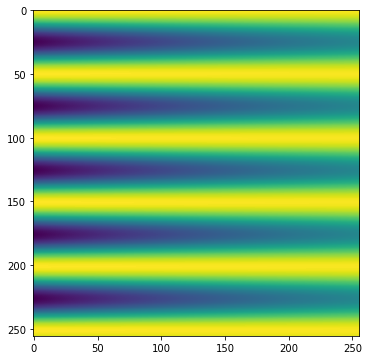

In [1]:
import numpy as np

from utils import save, load
from library import *
from process_library_terms import *
import matplotlib.pyplot as plt

#import h5py
#with h5py.File('NSE2D/uvp-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/uvp2-0.001.mat', 'r') as mat:
#with h5py.File('NSE2D/tgv-0.001.mat', 'r') as mat:
    #P = np.array(mat['P'])
    #U = np.array(mat['U'])
    #V = np.array(mat['V'])
    
#import netCDF4 as nc
#fn = '/path/to/file.nc4'
#ds = nc.Dataset(fn)

# for some reason, we need to fix the order of the axes
#P = np.transpose(P, (1, 2, 0))
#U = np.transpose(U, (1, 2, 0))
#V = np.transpose(V, (1, 2, 0))

Lx = 4; Ly = 4; Lt = 1;
#Nx = 512; Ny = Nx; Nt = 1000; # normal resolution
#Nx = 256; Ny = Nx; Nt = 1000; # half resolution
Nx = 256; Ny = Nx; Nt = Nx # analytical
dx = Lx/Nx; dy = Ly/Ny; dt = Lt/Nt;

# don't use MATLAB data
x = np.arange(0, 4, dx); y = np.arange(0, 4, dy); t = np.arange(0, 1, dt)
xg, yg = np.meshgrid(x, y)
U = 4*np.einsum('i,j,k->ijk', np.sin(4*x), np.cos(4*y), np.exp(-0.32*t))
V = -4*np.einsum('i,j,k->ijk', np.cos(4*x), np.sin(4*y), np.exp(-0.32*t))
P = 4*np.einsum('ij, k->ijk', np.cos(8*xg)+np.cos(8*yg), np.exp(-0.64*t))

fig, ax= plt.subplots(figsize=(6,6))
ax.imshow(P[:, 128, :])

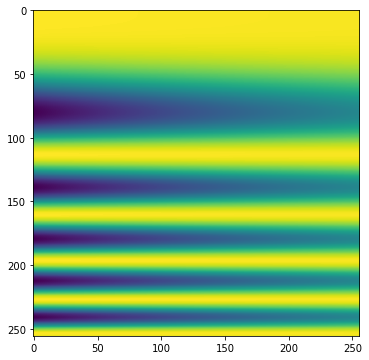

In [2]:
from utils import resample_grid

x_resample = np.arange(0, 4, dx)**2/4
P_res = resample_grid(P, x, x_resample, axis=0, order=5)
fig, ax= plt.subplots(figsize=(6,6))
diff = (P_res-P)[:, 128, :]
ax.imshow(P_res[:, 128, :])
#ax.imshow(diff)

0.00567823071366147

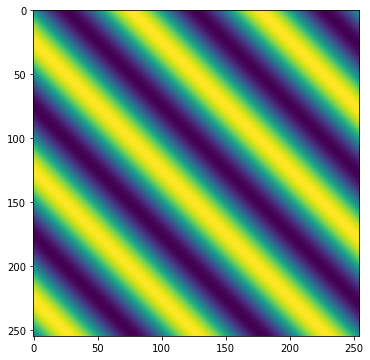

In [3]:
fig, ax= plt.subplots(figsize=(6,6))
dU = np.diff(U[:, :, -1], axis=0)
dV = np.diff(V[:, :, -1], axis=1)
ax.imshow(dU[:,1:]+dV[1:,:])
np.max(dU[:,1:]+dV[1:,:])

In [4]:
uobs = Observable('u', 1)
pobs = Observable('p', 0)
observables = [uobs, pobs]

u = np.concatenate([U[:, :, :, np.newaxis], V[:, :, :, np.newaxis]], axis=3)

### define all parameters and "make library"
terms = generate_terms_to(3, observables=observables, max_observables=3)
terms0 = []
terms1 = []
for term in terms:
    if term.rank==0:
        terms0.append(term)
    else:
        terms1.append(term)

world_size = np.array(U.shape)
m = 12
qmax = 1
nweights = qmax**4
ndomains = 30 #250
wx = 64
wt = 50
pad = 0


In [5]:
# %%prun

# fix random seed
np.random.seed(1)

data_dict = {'p': P, 'u': u}

dxs = [dx, dy, dt]

scale_dict = find_scales(data_dict)

char_sizes0 = [get_char_size(term, scale_dict, dx, dt) for term in terms0]
char_sizes1 = [get_char_size(term, scale_dict, dx, dt) for term in terms1]

weights = []
dxs_weight = [(wx-1)/2*dx, (wx-1)/2*dx, (wt-1)/2*dt] # grid spacing used by weight function

#for domain in domains:
for q1 in range(qmax):
    for q2 in range(qmax):
        for q3 in range(qmax):
            for q4 in range(qmax):
                weights.append(Weight([m]*3, [q1, q2, q3], [0]*3, dxs=dxs_weight))
#domains = domains*nweights

# make domains and "count" density
domains = make_domains([wx, wx, wt], world_size, ndomains, pad)

Q0 = make_library(terms0, data_dict, weights, domains, 0, dxs, debug=False)#, by_parts=False)
Q1 = make_library(terms1, data_dict, weights, domains, 1, dxs, debug=False)#, by_parts=False)

In [6]:
from identify_models import *

opts = dict()
opts['threshold'] = "'threshold'"
opts['gamma'] = 2
opts['verbose'] = False
opts['brute_force'] = False
opts['delta'] = 1e-8 # apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#opts['n_terms'] = 3
opts1 = opts.copy()
opts1['char_sizes'] = char_sizes1
#eqs0, lambdas0, derived_eqs0, excluded_terms = identify_equations(Q0, opts, terms0, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True)
#print(excluded_terms)
#eqs1, lambdas1, derived_eqs1, excluded_terms = identify_equations(Q1, opts1, terms1, observables, threshold=1e-5, 
#                       max_complexity=None, max_equations=999, timed=True, excluded_terms=excluded_terms)
#print(excluded_terms)
eqs, lambdas, derived_eqs, excluded_terms = interleave_identify([Q0, Q1], [opts, opts1], [terms0, terms1],
                                                        observables, threshold=1e-5)

#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 7.50e-09)
#Identified model: 0.9999999997998261 * di p + 1.0 * dj u_i * u_j = 0 (order 3, residual 2.08e-08)

[0.00 s]
Identified model: 1.0 * dt p + 0.6399999999993811 * p = 0 (order 2, residual 8.12e-17)
[0.01 s]
Identified model: 1.0 * dj u_j = 0 (order 2, residual 6.57e-16)
[0.00 s]
Identified model: 1.0 * dt u_i + 0.31999999999954154 * u_i = 0 (order 2, residual 1.81e-16)
[0.01 s]
Identified model: 0.015625000000002342 * dj^2 p + 1.0 * p = 0 (order 3, residual 6.07e-16)
[0.01 s]
Identified model: 0.03125000000004563 * dj^2 u_i + 1.0 * u_i = 0 (order 3, residual 8.66e-16)
[0.01 s]
Identified model: 0.9999999997872908 * di p + -2.1270893705013155e-10 * u_j * di u_j + 1.0 * u_j * dj u_i = 0 (order 3, residual 1.94e-15)
[0.02 s]
Identified model: 0.9999999997877307 * di p + 5.3927044471830976e-11 * p * di p + 1.0 * u_j * dj u_i = 0 (order 3, residual 1.20e-11)
[0.02 s]
Identified model: 0.9999999997998261 * di p + 1.0 * u_j * dj u_i = 0 (order 3, residual 3.18e-11)


In [7]:
from sparse_reg import *
#from ipynb.fs.full.sparse_reg import *
opts = dict()
#opts['threshold'] = "'pareto'"
#opts['verbose'] = True
#opts['brute_force'] = False
opts['threshold'] = "'threshold'"
opts['n_terms'] = len(terms0)
opts['gamma'] = 2
opts['verbose'] = False
opts['delta'] = 1e-8 #apparently this reaches machine precision as the relative error
opts['char_sizes'] = char_sizes0
#Xi, lambd, best_term, lambda1 = sparse_reg(Q0, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q0, **opts)

In [8]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms0[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print(f"Best term (#{best_term}):", terms0[best_term])

[Term 5] 0.639999999999528 * p * p
[Term 6] 1.0 * p * dt p
Model residual: 1.0761410493977036e-16
One-term model residual: 2.6353504447275667e-16
Best term (#11): p * dj u_j


In [9]:
opts['char_sizes'] = char_sizes1
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)

In [10]:
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 9] -0.5000000000000197 * dt p * u_i
[Term 10] 1.0 * p * dt u_i
Model residual: 4.8169733186782594e-17
One-term model residual: 2.7749893516294235e-12
Best term: di dj u_j


In [11]:
avoid = []
avoid.append(Xi)
opts['avoid'] = avoid
opts['verbose'] = False
Xi, lambd, best_term, lambda1 = sparse_reg(Q1, **opts)
#Xi, lambd, best_term, lambda1 = sparse_reg(Q1, opts)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {terms1[i]}")
print("Model residual:", lambd)
print("One-term model residual:", lambda1)
print("Best term:", terms1[best_term])

[Term 8] 0.8012258632790923 * p * u_i
[Term 9] 1.0 * dt p * u_i
[Term 10] 0.5038308227470396 * p * dt u_i
Model residual: 5.512480643321673e-17
One-term model residual: 2.7749893516294235e-12
Best term: di dj u_j


In [12]:
for term, size in zip(terms0, char_sizes0):
    print(term, size)
for term, size in zip(terms1, char_sizes1):
    print(term, size)

1 1
p 2.4154429198742573
dj^2 p 3.0301881069336614
dt p 3.0301881069336614
dt^2 p 3.0301881069336614
p * p 5.834364499170678
p * dt p 7.319246408780091
p * p * p 14.092574421487532
dj u_j 1.719653316635871
dt dj u_j 1.719653316635871
dj p * u_j 4.185548792356015
p * dj u_j 4.153724428306399
u_j * u_j 1.9079440694028171
u_j * dt u_j 2.3753287283540456
p * u_j * u_j 4.608529993955113
di p 3.0301881069336614
dt di p 3.0301881069336614
p * di p 7.319246408780091
u_i 1.3812834862557422
di dj u_j 1.719653316635871
dj^2 u_i 1.719653316635871
dt u_i 1.719653316635871
dt^2 u_i 1.719653316635871
p * u_i 3.3364114172156634
dt p * u_i 4.185548792356015
p * dt u_i 4.153724428306399
p * p * u_i 8.058911335501211
u_i * dj u_j 2.3753287283540456
u_j * di u_j 2.3753287283540456
u_j * dj u_i 2.3753287283540456
u_i * u_j * u_j 2.6354116357656907
